# UFC 경기 승패 예측 (최종 오류 수정)

## 1. 라이브러리 임포트 및 데이터 로드

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [332]:
df_original = pd.read_csv('UFC.csv')
# **[최종 오류 수정]** 모든 컬럼명을 소문자로 변환하고 양쪽 공백을 제거하여 컬럼명 오류를 원천 차단합니다.
df_original.columns = [col.strip().lower() for col in df_original.columns]

df = df_original.copy()

## 2. 전처리 및 특성 공학

In [333]:
# [전처리] 불필요 컬럼 제거 및 결측치 처리
df.dropna(subset=['winner', 'r_dob', 'b_dob', 'r_stance', 'b_stance', 'r_height', 'b_height'], inplace=True)
df['r_reach'].fillna(df['r_height'], inplace=True)
df['b_reach'].fillna(df['b_height'], inplace=True)

# [특성 공학] 타겟 변수 및 파생 변수 생성
df['winner_is_red'] = (df['winner'] == df['r_name']).astype(int)
df['r_dob'] = pd.to_datetime(df['r_dob'])
df['b_dob'] = pd.to_datetime(df['b_dob'])
df['r_age'] = (pd.to_datetime('today') - df['r_dob']).dt.days / 365.25
df['b_age'] = (pd.to_datetime('today') - df['b_dob']).dt.days / 365.25
df.drop(['r_dob', 'b_dob'], axis=1, inplace=True)

# 차이 특성
df['age_diff'] = df['r_age'] - df['b_age']
df['height_diff'] = df['r_height'] - df['b_height']
df['reach_diff'] = df['r_reach'] - df['b_reach']
df['wins_diff'] = df['r_wins'] - df['b_wins']
df['losses_diff'] = df['r_losses'] - df['b_losses']
df['splm_diff'] = df['r_splm'] - df['b_splm']
df['str_acc_diff'] = df['r_str_acc'] - df['b_str_acc']
df['sapm_diff'] = df['r_sapm'] - df['b_sapm']
df['str_def_diff'] = df['r_str_def'] - df['b_str_def']
df['td_avg_diff'] = df['r_td_avg'] - df['b_td_avg']
df['td_acc_diff'] = df['r_td_avg_acc'] - df['b_td_avg_acc']
df['td_def_diff'] = df['r_td_def'] - df['b_td_def']
df['sub_avg_diff'] = df['r_sub_avg'] - df['b_sub_avg']

# 비율 및 복합 특성
# ratio features (0~1 scaled)
df['sig_str_ratio'] = df['r_splm'] / (df['r_splm'] + df['b_splm'] + 1e-6)
df['td_ratio'] = df['r_td_avg'] / (df['r_td_avg'] + df['b_td_avg'] + 1e-6)
df['str_acc_ratio'] = df['r_str_acc'] / (df['r_str_acc'] + df['b_str_acc'] + 1e-6)
df['td_acc_ratio'] = df['r_td_avg_acc'] / (df['r_td_avg_acc'] + df['b_td_avg_acc'] + 1e-6)

# win ratio features
df['r_win_ratio'] = df['r_wins'] / (df['r_wins'] + df['r_losses'] + 1e-6)
df['b_win_ratio'] = df['b_wins'] / (df['b_wins'] + df['b_losses'] + 1e-6)
df['win_ratio_diff'] = df['r_win_ratio'] - df['b_win_ratio']

# ---------- 추가 파생 특성 ----------
# BMI
df['r_bmi'] = df['r_weight'] / ((df['r_height'] / 100) ** 2 + 1e-6)
df['b_bmi'] = df['b_weight'] / ((df['b_height'] / 100) ** 2 + 1e-6)
df['bmi_diff'] = df['r_bmi'] - df['b_bmi']

# Reach / Height 비율
df['r_reach_ht_ratio'] = df['r_reach'] / (df['r_height'] + 1e-6)
df['b_reach_ht_ratio'] = df['b_reach'] / (df['b_height'] + 1e-6)
df['reach_ht_ratio_diff'] = df['r_reach_ht_ratio'] - df['b_reach_ht_ratio']


# 총 경기 수
df['r_total_fights'] = df['r_wins'] + df['r_losses']
df['b_total_fights'] = df['b_wins'] + df['b_losses']
df['total_fights_diff'] = df['r_total_fights'] - df['b_total_fights']

# ---------- 추가 파생 특성 v3 ----------
# 1) 공격 점수: Striking + Grappling 효율 합
df['r_offense_score'] = df['r_str_eff'] + df['r_grap_eff'] if 'r_str_eff' in df.columns else \
                        (df['r_splm'] * df['r_str_acc']) + (df['r_td_avg'] * df['r_td_avg_acc'])
df['b_offense_score'] = df['b_str_eff'] + df['b_grap_eff'] if 'b_str_eff' in df.columns else \
                        (df['b_splm'] * df['b_str_acc']) + (df['b_td_avg'] * df['b_td_avg_acc'])
df['offense_score_diff'] = df['r_offense_score'] - df['b_offense_score']

# 2) 방어 점수: 타격·테이크다운 방어율 평균
df['r_defense_score'] = (df['r_str_def'] + df['r_td_def']) / 2
df['b_defense_score'] = (df['b_str_def'] + df['b_td_def']) / 2
df['defense_score_diff'] = df['r_defense_score'] - df['b_defense_score']

# 3) 순공격 이득(Net Advantage) = 공격 diff + 방어 diff
df['net_advantage'] = df['offense_score_diff'] + df['defense_score_diff']

# 4) 상호작용 특성: 레드의 공격 vs 블루의 방어, 블루의 공격 vs 레드의 방어
df['str_vs_def_diff'] = (df['r_str_acc'] * df['b_str_def']) - (df['b_str_acc'] * df['r_str_def'])

# 5) 공격/방어 스코어 비율 차이
df['off_def_ratio_diff'] = (df['r_offense_score'] / (df['r_defense_score'] + 1e-6)) - \
                           (df['b_offense_score'] / (df['b_defense_score'] + 1e-6))

# 스탠스 조합 (범주형)
df['stance_comb'] = df['r_stance'].astype(str) + '_' + df['b_stance'].astype(str)


## 3. 모델링 준비 (모든 특성 사용)

In [334]:
# 모든 생성된 특성 정의
numerical_features = [col for col in df.columns if df[col].dtype != 'object' and col not in ['winner_is_red', 'winner']]
categorical_features = ['r_stance', 'b_stance', 'stance_comb']

# 최종 데이터셋 정의 및 분할
X = df[numerical_features + categorical_features]
y = df['winner_is_red']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'사용된 총 특성 개수: {X_train.shape[1]}')

사용된 총 특성 개수: 75


## 4. 스태킹 모델 하이퍼파라미터 튜닝

In [335]:
# 전처리기 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)])

# 클래스 불균형 처리 가중치
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# 스태킹 기본 모델 정의
estimators = [
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('lgb', LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)),
    ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))
]

# 스태킹 모델 파이프라인 구축
stacking_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                    ('classifier', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5))])

# 튜닝할 하이퍼파라미터 그리드 정의
param_distributions = {
    'classifier__rf__n_estimators': [200],
    'classifier__rf__max_depth': [5],
    'classifier__lgb__n_estimators': [300],
    'classifier__lgb__learning_rate': [0.01],
    'classifier__lgb__num_leaves': [20],
    'classifier__xgb__n_estimators': [300],
    'classifier__xgb__max_depth': [7],
    'classifier__xgb__learning_rate': [0.05],
    'classifier__final_estimator__C': [0.1]
}

# RandomizedSearchCV 실행
search = RandomizedSearchCV(stacking_pipeline, param_distributions, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=2)
print("--- Stacking Model Hyperparameter Tuning ---")
search.fit(X_train, y_train)

print(f'Best ROC-AUC Score: {search.best_score_:.4f}')
print("Best Parameters:")
print(search.best_params_)

--- Stacking Model Hyperparameter Tuning ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best ROC-AUC Score: 0.8118
Best Parameters:
{'classifier__xgb__n_estimators': 300, 'classifier__xgb__max_depth': 7, 'classifier__xgb__learning_rate': 0.05, 'classifier__rf__n_estimators': 200, 'classifier__rf__max_depth': 5, 'classifier__lgb__num_leaves': 20, 'classifier__lgb__n_estimators': 300, 'classifier__lgb__learning_rate': 0.01, 'classifier__final_estimator__C': 0.1}


## 5. 최종 모델 평가

--- Final Tuned Stacking Ensemble Model ---
Accuracy: 0.7481
ROC-AUC: 0.8163
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       570
           1       0.79      0.83      0.81      1002

    accuracy                           0.75      1572
   macro avg       0.73      0.72      0.72      1572
weighted avg       0.74      0.75      0.75      1572



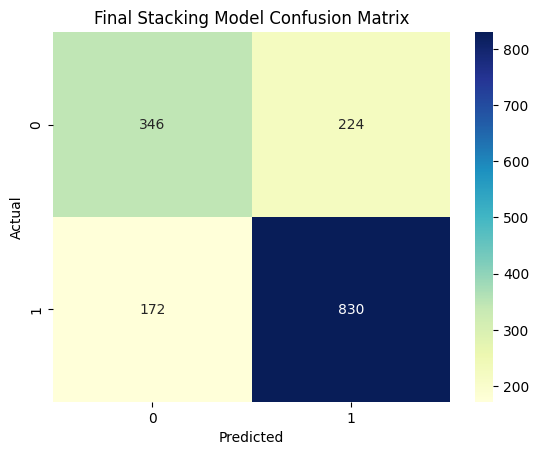

In [336]:
# 최적의 모델로 예측 및 평가
best_stacking_model = search.best_estimator_

probs_final = best_stacking_model.predict_proba(X_test)[:, 1]
y_pred_final = (probs_final >= 0.5).astype(int)

print('--- Final Tuned Stacking Ensemble Model ---')
print(f'Accuracy: {accuracy_score(y_test, y_pred_final):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, probs_final):.4f}')
print(classification_report(y_test, y_pred_final))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Final Stacking Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. 최종 모델을 활용한 승자 예측 (오류 수정 v2)

In [337]:
import random
import pandas as pd

def get_fighter_stats(fighter_name, original_df):
    # 선수의 최신 데이터를 가져옵니다.
    if 'date' in original_df.columns:
        original_df['date'] = pd.to_datetime(original_df['date'])
        fighter_df = original_df[(original_df['r_name'] == fighter_name) | (original_df['b_name'] == fighter_name)].sort_values(by='date', ascending=False)
    else:
        # 날짜 정보가 없으면 마지막 경기를 특정할 수 없으므로 가장 최근 인덱스를 사용합니다.
        fighter_df = original_df[(original_df['r_name'] == fighter_name) | (original_df['b_name'] == fighter_name)]

    if fighter_df.empty:
        return None
    
    latest_fight = fighter_df.iloc[0]
    
    # 해당 선수가 'r'이었는지 'b'이었는지 확인하여 통계를 추출합니다.
    prefix = 'r_' if latest_fight['r_name'] == fighter_name else 'b_'
    stats = {col.replace(prefix, ''): latest_fight[col] for col in latest_fight.index if col.startswith(prefix)}
    return stats

def predict_win_probability(fighter1_name, fighter2_name, original_df, model, X_cols):
    # 1. 각 선수의 통계 가져오기
    fighter1_stats = get_fighter_stats(fighter1_name, original_df)
    fighter2_stats = get_fighter_stats(fighter2_name, original_df)

    if fighter1_stats is None:
        print(f'''Error: Fighter '{fighter1_name}' not found.''')
        return
    if fighter2_stats is None:
        print(f'''Error: Fighter '{fighter2_name}' not found.''')
        return

    # 2. 예측을 위한 데이터프레임 생성
    r_stats = {f'r_{key}': val for key, val in fighter1_stats.items()}
    b_stats = {f'b_{key}': val for key, val in fighter2_stats.items()}
    matchup_data = {**r_stats, **b_stats}
    matchup_df = pd.DataFrame([matchup_data])

    # [오류 수정] 모델 학습에 필요한 기본 스탯 컬럼이 누락된 경우 0으로 채웁니다.
    base_columns = [
        'r_height', 'r_reach', 'r_weight', 'r_dob', 'r_wins', 'r_losses', 'r_splm', 'r_str_acc', 'r_sapm', 'r_str_def', 'r_td_avg', 'r_td_avg_acc', 'r_td_def', 'r_sub_avg', 'r_stance',
        'b_height', 'b_reach', 'b_weight', 'b_dob', 'b_wins', 'b_losses', 'b_splm', 'b_str_acc', 'b_sapm', 'b_str_def', 'b_td_avg', 'b_td_avg_acc', 'b_td_def', 'b_sub_avg', 'b_stance'
    ]
    for col in base_columns:
        if col not in matchup_df.columns:
            # DOB는 날짜 계산을 위해 유효한 날짜 문자열로, 나머지는 0.0으로 채웁니다.
            if 'dob' in col:
                matchup_df[col] = '1990-01-01' 
            elif 'stance' in col:
                 matchup_df[col] = 'Orthodox' # 가장 흔한 스탠스로 채웁니다.
            else:
                matchup_df[col] = 0.0

    # 3. 훈련 과정에서 생성된 모든 파생 변수 추가
    for col in ['r_dob', 'b_dob']:
        matchup_df[col] = pd.to_datetime(matchup_df[col])
    matchup_df['r_age'] = (pd.to_datetime('today') - matchup_df['r_dob']).dt.days / 365.25
    matchup_df['b_age'] = (pd.to_datetime('today') - matchup_df['b_dob']).dt.days / 365.25

    matchup_df['r_reach'].fillna(matchup_df['r_height'], inplace=True)
    matchup_df['b_reach'].fillna(matchup_df['b_height'], inplace=True)

    diff_features = {
        'age_diff': ('r_age', 'b_age'), 'height_diff': ('r_height', 'b_height'),
        'reach_diff': ('r_reach', 'b_reach'), 'wins_diff': ('r_wins', 'b_wins'),
        'losses_diff': ('r_losses', 'b_losses'), 'splm_diff': ('r_splm', 'b_splm'),
        'str_acc_diff': ('r_str_acc', 'b_str_acc'), 'sapm_diff': ('r_sapm', 'b_sapm'),
        'str_def_diff': ('r_str_def', 'b_str_def'), 'td_avg_diff': ('r_td_avg', 'b_td_avg'),
        'td_acc_diff': ('r_td_avg_acc', 'b_td_avg_acc'), 'td_def_diff': ('r_td_def', 'b_td_def'),
        'sub_avg_diff': ('r_sub_avg', 'b_sub_avg')
    }
    for new_feat, (r_feat, b_feat) in diff_features.items():
        matchup_df[new_feat] = matchup_df[r_feat] - matchup_df[b_feat]

    matchup_df['sig_str_ratio'] = matchup_df['r_splm'] / (matchup_df['r_splm'] + matchup_df['b_splm'] + 1e-6)
    matchup_df['td_ratio'] = matchup_df['r_td_avg'] / (matchup_df['r_td_avg'] + matchup_df['b_td_avg'] + 1e-6)
    matchup_df['str_acc_ratio'] = matchup_df['r_str_acc'] / (matchup_df['r_str_acc'] + matchup_df['b_str_acc'] + 1e-6)
    matchup_df['td_acc_ratio'] = matchup_df['r_td_avg_acc'] / (matchup_df['r_td_avg_acc'] + matchup_df['b_td_avg_acc'] + 1e-6)
    matchup_df['r_win_ratio'] = matchup_df['r_wins'] / (matchup_df['r_wins'] + matchup_df['r_losses'] + 1e-6)
    matchup_df['b_win_ratio'] = matchup_df['b_wins'] / (matchup_df['b_wins'] + matchup_df['b_losses'] + 1e-6)
    matchup_df['win_ratio_diff'] = matchup_df['r_win_ratio'] - matchup_df['b_win_ratio']
    matchup_df['r_bmi'] = matchup_df['r_weight'] / ((matchup_df['r_height'] / 100) ** 2 + 1e-6)
    matchup_df['b_bmi'] = matchup_df['b_weight'] / ((matchup_df['b_height'] / 100) ** 2 + 1e-6)
    matchup_df['bmi_diff'] = matchup_df['r_bmi'] - matchup_df['b_bmi']
    matchup_df['r_reach_ht_ratio'] = matchup_df['r_reach'] / (matchup_df['r_height'] + 1e-6)
    matchup_df['b_reach_ht_ratio'] = matchup_df['b_reach'] / (matchup_df['b_height'] + 1e-6)
    matchup_df['reach_ht_ratio_diff'] = matchup_df['r_reach_ht_ratio'] - matchup_df['b_reach_ht_ratio']
    matchup_df['r_total_fights'] = matchup_df['r_wins'] + matchup_df['r_losses']
    matchup_df['b_total_fights'] = matchup_df['b_wins'] + matchup_df['b_losses']
    matchup_df['total_fights_diff'] = matchup_df['r_total_fights'] - matchup_df['b_total_fights']
    matchup_df['r_offense_score'] = (matchup_df['r_splm'] * matchup_df['r_str_acc']) + (matchup_df['r_td_avg'] * matchup_df['r_td_avg_acc'])
    matchup_df['b_offense_score'] = (matchup_df['b_splm'] * matchup_df['b_str_acc']) + (matchup_df['b_td_avg'] * matchup_df['b_td_avg_acc'])
    matchup_df['offense_score_diff'] = matchup_df['r_offense_score'] - matchup_df['b_offense_score']
    matchup_df['r_defense_score'] = (matchup_df['r_str_def'] + matchup_df['r_td_def']) / 2
    matchup_df['b_defense_score'] = (matchup_df['b_str_def'] + matchup_df['b_td_def']) / 2
    matchup_df['defense_score_diff'] = matchup_df['r_defense_score'] - matchup_df['b_defense_score']
    matchup_df['net_advantage'] = matchup_df['offense_score_diff'] + matchup_df['defense_score_diff']
    matchup_df['str_vs_def_diff'] = (matchup_df['r_str_acc'] * matchup_df['b_str_def']) - (matchup_df['b_str_acc'] * matchup_df['r_str_def'])
    matchup_df['off_def_ratio_diff'] = (matchup_df['r_offense_score'] / (matchup_df['r_defense_score'] + 1e-6)) - (matchup_df['b_offense_score'] / (matchup_df['b_defense_score'] + 1e-6))
    matchup_df['stance_comb'] = matchup_df['r_stance'].astype(str) + '_' + matchup_df['b_stance'].astype(str)

    # 4. 모델이 학습한 특성 순서대로 정렬
    matchup_df_final = matchup_df[X_cols]

    # 5. 승리 확률 예측
    win_prob = model.predict_proba(matchup_df_final)[0] # [P(Blue win), P(Red win)]

    # 6. 결과 출력
    print('='*50)
    print(f'Matchup: {fighter1_name} (Red) vs. {fighter2_name} (Blue)')
    print(f'>> {fighter1_name} (Red) Win Probability: {win_prob[1]*100:.2f}%')
    print(f'>> {fighter2_name} (Blue) Win Probability: {win_prob[0]*100:.2f}%')
    print('='*50)

# --- 예측 실행 ---
try:
    # df_original에서 선수 목록을 가져옵니다.
    all_fighters = pd.concat([df_original['r_name'], df_original['b_name']]).dropna().unique()

    # 랜덤으로 두 명의 선수를 선택합니다.
    random_fighters = random.sample(list(all_fighters), 2)
    fighter1 = random_fighters[0]
    fighter2 = random_fighters[1]

    # 예측 함수 호출
    # best_stacking_model과 X_train.columns는 이전 셀에서 생성되어야 합니다.
    predict_win_probability(fighter1, fighter2, df_original, best_stacking_model, X_train.columns)

    # 예시: 특정 선수들로 예측
    predict_win_probability('Conor McGregor', 'Islam Makhachev', df_original, best_stacking_model, X_train.columns)
except NameError as e:
    print('---'*20)
    print('모델 또는 데이터가 아직 준비되지 않았습니다.')
    print('노트북의 모든 셀을 실행한 후 다시 시도해 주세요.')
    print(f'(오류: {e})')
    print('---'*20)
except Exception as e:
    print(f'예측 중 오류가 발생했습니다: {e}')

예측 중 오류가 발생했습니다: "['title_fight', 'finish_round', 'match_time_sec', 'total_rounds'] not in index"
